# Inspection detector variations

**_must run with dfs created with the 2-PFP cut_**

This notebook inspects the selection after the 2-PFP requirement, where the decrease in efficiency grows significant


- inspect cut variable distributions, compare data vs. MC
- optimize PID cuts in favor of purity over efficiency
- evalutes reconstruction resolution of kinematic variables to measure

In [1050]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm

# local imports
sys.path.append('../../')
from analysis_village.numucc1p0pi.variable_configs import VariableConfig
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
from matplotlib.colors import LogNorm

In [1051]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from matplotlib.offsetbox import AnchoredOffsetbox, DrawingArea, HPacker, VPacker, TextArea
from matplotlib.legend import Legend

In [1052]:
def match_trkdf_to_slcdf(trkdf, slcdf):
    # trkdf: df to match
    # slcdf: df to match to
    matched_trkdf = trkdf.reset_index(level=[3]).loc[slcdf.index].reset_index().set_index(trkdf.index.names)
    return matched_trkdf


In [1053]:
def mag3d(df1, df2):
    return np.sqrt((df1.x - df2.x)**2 + (df1.y - df2.y)**2 + (df1.z - df2.z)**2)

In [1102]:
save_fig = True
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/detector_variations/calo_R"
# save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/detector_variations/SCE"
# save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/detector_variations/PDS"

colors = ["black", "C0", "C1", "C2"]
# labels = list(detvar_dfs.keys())
# labels = ["CV", r"$\tau_e$ = 10ms", r"$\tau_e$ = 35ms", r"$\tau_e$ = 50ms"]
# labels = ["CV", r"$\alpha$ -1$\sigma$", r"$\alpha$ +1$\sigma$"]
# labels = ["CV", r"$\beta$ -1$\sigma$", r"$\beta$ +1$\sigma$"]
labels = ["CV", r"$R$ -1$\sigma$", r"$R$ +1$\sigma$"]
# labels = ["CV", "0xSCE", "2xSCE"]
# labels = ["CV", "LowEff", "HighNoise", "GainFluct"]

# colors = ["black", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
# # labels = ["CV", r"$R$ -1$\sigma$", r"$R$ +1$\sigma$"]
# labels = list(detvar_dfs.keys())

# Load dfs

In [1103]:
## target pot - scale to data POT
data_tot_pot = 5.98e18
pot_str = "5.98 $\\times 10^{18}$"

In [1104]:
# # SCE variations
# detvar_dfs = {}

# n_max_concat = 5
# mc_keys2load = ['hdr', 'evt'] 

# file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"

# # files = {"CV": "MC_bnb_cosmics_detvar_CV-2prong.df",
# #          "0xSCE":"MC_bnb_cosmics_detvar_0xSCE-2prong.df",
# #          "2xSCE":"MC_bnb_cosmics_detvar_2xSCE-2prong.df"}

# files = {"CV": "MC_bnb_cosmics_detvar_CV-2prong.df",
#          "PMTLowEff":"MC_bnb_cosmics_detvar_PMTLowEff.df",
#          "PMTHighNoise":"MC_bnb_cosmics_detvar_PMTHighNoise.df",
#          "PMTGainFluct": "MC_bnb_cosmics_detvar_PMTGainFluct.df"}

# # files = {"CV": "MC_bnb_cosmics_detvar_CV-2prong.df",
# #          "etau10":"MC_bnb_cosmics_detvar_etau10_2prong.df.df",
# #          "etau35":"MC_bnb_cosmics_detvar_etau35_2prong.df.df",
# #          "etau50": "MC_bnb_cosmics_detvar_etau50_2prong.df.df"}


# ## -- CV
# for fkey in files.keys():
#     mc_file = path.join(file_dir, files[fkey])

#     mc_split_df = pd.read_hdf(mc_file, key="split")
#     mc_n_split = get_n_split(mc_file)
#     print("mc_n_split: %d" %(mc_n_split))
#     print_keys(mc_file)

#     mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
#     mc_hdr_df = mc_dfs['hdr']
#     mc_evt_df = mc_dfs['evt']

#     mc_tot_pot = mc_hdr_df['pot'].sum()
#     print("mc_tot_pot: %.3e" %(mc_tot_pot))
#     mc_pot_scale = data_tot_pot / mc_tot_pot
#     print("mc_pot_scale: %.3e" %(mc_pot_scale))
#     mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

#     mc_track1 = mc_evt_df.t1
#     mc_track2 = mc_evt_df.t2
#     trk_indexnames = list(mc_track1.index.names) + [("pfp", "tindex", "", "", "", "", "")]
#     mc_trk_df = pd.concat([mc_track1.reset_index().set_index(trk_indexnames),
#                                 mc_track2.reset_index().set_index(trk_indexnames)])
#     mc_trk_df["pot_weight"] = np.ones(len(mc_trk_df))*mc_pot_scale
#     mc_dfs['trk'] = mc_trk_df

#     detvar_dfs[fkey] = mc_dfs

In [1105]:
# calo variations
detvar_dfs = {}
filename = "MC_bnb_cosmics_detvar_recomb_2prong_test.df"
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"
mc_file = path.join(file_dir, filename)

mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']

mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))
mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_track1 = mc_evt_df.t1
mc_track2 = mc_evt_df.t2
trk_indexnames = list(mc_track1.index.names) + [("pfp", "tindex", "", "", "", "", "")]
mc_trk_df = pd.concat([mc_track1.reset_index().set_index(trk_indexnames),
                            mc_track2.reset_index().set_index(trk_indexnames)])
mc_trk_df["pot_weight"] = np.ones(len(mc_trk_df))*mc_pot_scale
mc_dfs['trk'] = mc_trk_df

detvar_dfs["CV"] = {"evt": mc_evt_df, "trk": mc_trk_df, "hdr": mc_hdr_df}
# 
# for alpha_sig in [-1, 0, 1]:
#     for beta_sig in [-1, 0, 1]:
#         for R_sig in [-1, 0, 1]:
#             sign_tag = {1: "p", 0: "cv", -1: "m"}
#             recomb_tag = "A{}{}B{}{}R{}{}".format(sign_tag[alpha_sig], np.abs(alpha_sig), sign_tag[beta_sig], np.abs(beta_sig), sign_tag[R_sig], np.abs(R_sig))

#             for plane in [0, 1, 2]:
#                 for pid in ["muon", "pion", "proton"]:
#                     mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]

#             detvar_dfs[recomb_tag] = {"evt": mc_evt_df, "trk": mc_trk_df, "hdr": mc_hdr_df}

# for alpha_sig in [-1, 1]:
#     for beta_sig in [-1,  1]:
#         for R_sig in [-1, 1]:
#             sign_tag = {1: "p", 0: "cv", -1: "m"}
#             recomb_tag = "A{}{}B{}{}R{}{}".format(sign_tag[alpha_sig], np.abs(alpha_sig), sign_tag[beta_sig], np.abs(beta_sig), sign_tag[R_sig], np.abs(R_sig))

#             mc_evt_df_temp = mc_evt_df.copy()
#             for plane in [0, 1, 2]:
#                 for pid in ["muon", "pion", "proton"]:
#                     mc_evt_df_temp[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]
#                     mc_evt_df_temp[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]

#             detvar_dfs[recomb_tag] = {"evt": mc_evt_df_temp, "trk": mc_trk_df, "hdr": mc_hdr_df}

# for alpha_sig in [-1, 1]:
#     beta_sig = 0
#     R_sig = 0
#     sign_tag = {1: "p", 0: "cv", -1: "m"}
#     recomb_tag = "A{}{}B{}{}R{}{}".format(sign_tag[alpha_sig], np.abs(alpha_sig), sign_tag[beta_sig], np.abs(beta_sig), sign_tag[R_sig], np.abs(R_sig))

#     mc_evt_df_temp = mc_evt_df.copy()
#     for plane in [0, 1, 2]:
#         for pid in ["muon", "pion", "proton"]:
#             mc_evt_df_temp[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]
#             mc_evt_df_temp[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]

#     detvar_dfs[recomb_tag] = {"evt": mc_evt_df_temp, "trk": mc_trk_df, "hdr": mc_hdr_df}

# for beta_sig in [-1, 1]:
#     alpha_sig = 0
#     R_sig = 0
#     sign_tag = {1: "p", 0: "cv", -1: "m"}
#     recomb_tag = "A{}{}B{}{}R{}{}".format(sign_tag[alpha_sig], np.abs(alpha_sig), sign_tag[beta_sig], np.abs(beta_sig), sign_tag[R_sig], np.abs(R_sig))

#     mc_evt_df_temp = mc_evt_df.copy()
#     for plane in [0, 1, 2]:
#         for pid in ["muon", "pion", "proton"]:
#             mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]
#             mc_evt_df[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]

#     detvar_dfs[recomb_tag] = {"evt": mc_evt_df_temp, "trk": mc_trk_df, "hdr": mc_hdr_df}

for R_sig in [-1, 1]:
    alpha_sig = 0
    beta_sig = 0
    sign_tag = {1: "p", 0: "cv", -1: "m"}
    recomb_tag = "A{}{}B{}{}R{}{}".format(sign_tag[alpha_sig], np.abs(alpha_sig), sign_tag[beta_sig], np.abs(beta_sig), sign_tag[R_sig], np.abs(R_sig))

    mc_evt_df_temp = mc_evt_df.copy()
    for plane in [0, 1, 2]:
        for pid in ["muon", "pion", "proton"]:
            mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t1", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]
            mc_evt_df[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid, "", "")] = mc_evt_df[("t2", "pfp", "trk", "chi2pid", "I{}".format(plane), "chi2_"+pid+"_"+recomb_tag, "", "")]

    detvar_dfs[recomb_tag] = {"evt": mc_evt_df_temp, "trk": mc_trk_df, "hdr": mc_hdr_df}

print(detvar_dfs.keys())
print(len(detvar_dfs.keys()))

mc_n_split: 1
Keys: ['/evt_0', '/hdr_0', '/split']
mc_tot_pot: 1.504e+19
mc_pot_scale: 3.977e-01
dict_keys(['CV', 'Acv0Bcv0Rm1', 'Acv0Bcv0Rp1'])
3


# Plotter

In [1106]:
def hist_plot(evtdfs, vardfs, bins,
              colors, labels,
              plot_labels=["", "", ""],
              vline = None,
              approval="internal",
              save_fig=False, save_name=None): 

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    fig, axs = plt.subplots(2, 1, figsize=(7.5, 7), 
                            sharex=True, gridspec_kw={'height_ratios': [4, 1]})
    fig.subplots_adjust(hspace=0.05)
    ax = axs[0]
    ax_r = axs[1]

    total_mc_list = []
    mc_stat_err_list = []
    for i, (evtdf, vardf) in enumerate(zip(evtdfs, vardfs)):
        # scale_mc = evtdf.pot_weight.unique()[0]
        total_mc, _ = np.histogram(vardf, bins=bins, weights=evtdf.pot_weight)
        total_mc_err2, _ = np.histogram(vardf, bins=bins, weights=np.square(evtdf.pot_weight))
        mc_stat_err = np.sqrt(total_mc_err2)
        total_mc_list.append(total_mc)
        mc_stat_err_list.append(mc_stat_err)

        # ax.bar(
        #     bin_centers,
        #     2 * mc_stat_err,
        #     width=np.diff(bins),
        #     bottom=total_mc - mc_stat_err,
        #     facecolor=colors[i],
        #     edgecolor=colors[i],
        #     alpha=0.3,
        #     # linewidth=1.0,
        # )

        ax.hist(vardf, bins=bins, weights=evtdf.pot_weight, histtype="step", 
                 color=colors[i], label=labels[i])


    # ax.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_title(plot_labels[2])
    ax.set_xlim(bins[0], bins[-1])
    ax.legend()

    # ratio plot -- divide by the first df (CV)

    for i, (evtdf, vardf) in enumerate(zip(evtdfs, vardfs)):
        if i == 0:
            continue
        ratio = total_mc_list[i] / total_mc_list[0]
        # propagate the error from CV and this sample
        # for division
        this_err = np.sqrt(
            (mc_stat_err_list[0] / total_mc_list[0])**2 + 
            (mc_stat_err_list[i] / total_mc_list[i])**2
        )
        # ax_r.bar(
        #     bin_centers,
        #     2*this_err,
        #     width=np.diff(bins),
        #     bottom=ratio - this_err,
        #     facecolor=colors[i],
        #     edgecolor=colors[i],          # outline color of the hatching
        #     alpha=0.3,
        #     linewidth=0.0,
        #     label='MC Stat. Unc.'
        # )
        # Plot ignoring nan values in ratio
        ax_r.hist(bin_centers, bins=bins, weights=ratio, linewidth=1, histtype="step")

    ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
    
    ax_r.grid(True)
    ax_r.minorticks_on()
    ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

    ax_r.set_xlabel(plot_labels[0])
    ax_r.set_ylabel("Variation / CV")
    ax_r.set_xlim(bins[0], bins[-1])
    ax_r.set_ylim(0.5, 1.5)

    if vline is not None:
        for v in vline:
            ax.axvline(x=v, color='red', linestyle='--')
            ax_r.axvline(x=v, color='red', linestyle='--')

    # --- approval textbox
    # decide if the distribution is tilted to the right or left
    n_firsthalf = np.sum(total_mc[:len(bins)//2])
    n_secondhalf = np.sum(total_mc[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        textloc_ha = 'right'
    else:
        textloc_x = 0.05
        textloc_ha = 'left'

    if approval == "internal":
        ax.text(textloc_x, 0.65, "SBND Internal", transform=ax.transAxes, 
                fontsize=14, color='rosybrown',
                ha=textloc_ha, va='top')

    elif approval == "preliminary":
        ax.text(textloc_x, 0.65, "SBND Preliminary", transform=ax.transAxes, 
                fontsize=14, color='gray',
                ha=textloc_ha, va='top')

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    

In [1107]:
def bar_plot(type,
             evtdf,
             plot_labels=["", "", ""], 
             save_fig=False, save_name=None): #, scale, stage):

    if type == "nu_cosmics":
        ncateg = 3
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_intfv = IsNu(evtdf) & InFV(evtdf.slc.truth.position)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_intfv]

    elif type == "topology":
        ncateg = 7
        labels = topology_labels
        colors = topology_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)

        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif type == "genie":
        ncateg = 9
        labels = genie_labels
        colors = genie_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]

    else:
        raise ValueError("Invalid type: %s, please choose between [nu_cosmics, topolgy, or genie]" % type)


    fig, ax = plt.subplots(figsize = (6, ncateg*0.6))

    scale = evtdf.pot_weight.unique()[0]
    size = [scale*len(evtdf[i]) for i in cuts]
    # size = []

    # # make sure that the categories don't overlap
    # for i in range(len(cuts)):
    #     for j in range(i+1, len(cuts)):
    #         if (cuts[i] & cuts[j]).sum() > 0:
    #             print("Categories overlap:", labels[i], labels[j])
    # # and check if the categories cover all events
    # if not np.array(size).sum() == len(evtdf):
    #     print("Categories do not cover all events")
    #     print("Total events:", len(evtdf))
    #     print("Sum of categories:", np.array(size).sum())

    bars = plt.barh(labels, size, align='center', color = colors)
    tot_count = np.array(size).sum()
    
    perc_list = []
    for bar in bars:
        width = bar.get_width()
        label_y_pos = bar.get_y() + bar.get_height() / 2
        perc = 100*(width+0.)/(tot_count+0.)
        ax.text(width+1, label_y_pos, s= ("%0.2f"%(100*(width+0.)/(tot_count+0.)) + "%"), va='center')
        perc_list.append(perc)

    plt.xlabel(plot_labels[0])
    plt.xlim(0, 1.12 * np.max(size))

    if save_fig:
        plt.savefig(save_name, bbox_inches="tight")

    ret_dict = {"cuts": cuts,
                "perc_list": perc_list}
    return ret_dict

In [1108]:
plot_labels_bar = ["Events (POT={})".format(pot_str), "", ""]
plot_labels_hist = ["", "Events (POT={})".format(pot_str), ""]

# Collect Through Selection for Summary Plots

In [1109]:
df_dict = {var_key: {} for var_key in detvar_dfs.keys()} # for efficiency plot
perc_dict_topo = {var_key: {} for var_key in detvar_dfs.keys()}
perc_dict_genie = {var_key: {} for var_key in detvar_dfs.keys()}

# Selection

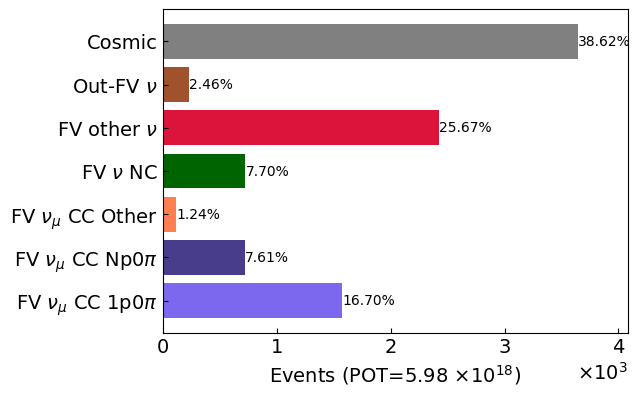

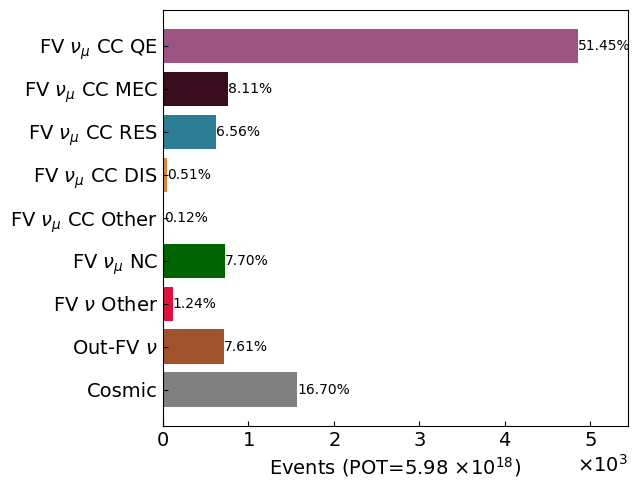

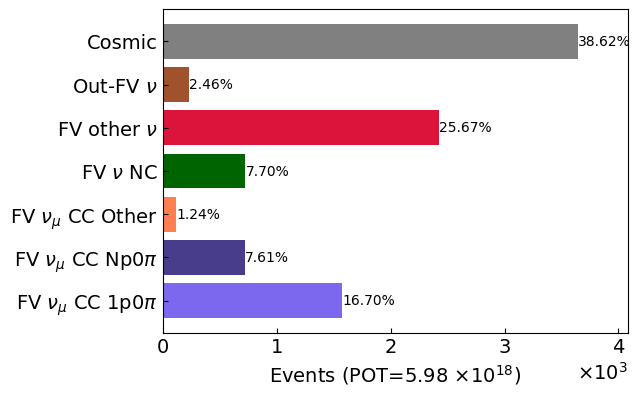

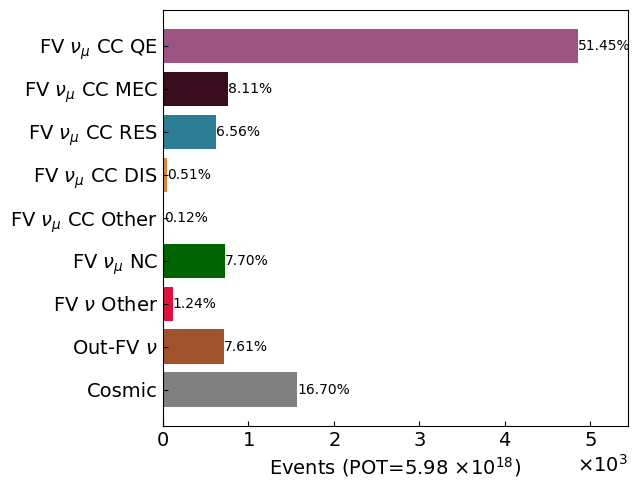

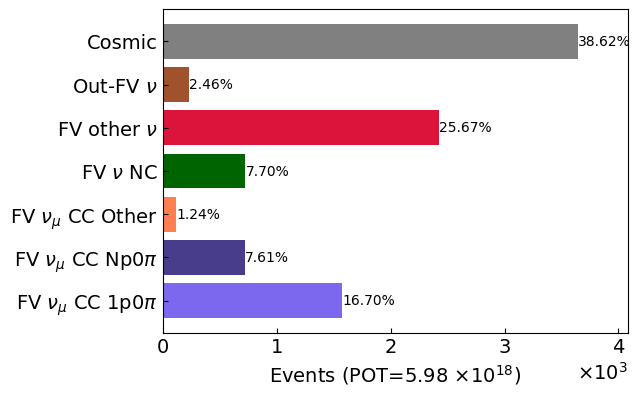

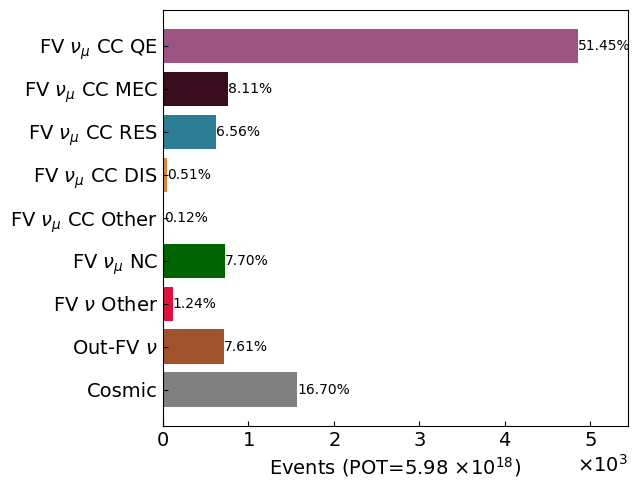

In [1110]:
stage_key = "2prong"

for var_key in detvar_dfs.keys():
    mc_evt_df = detvar_dfs[var_key]['evt']

    bar_type = "topology"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    bar_type = "genie"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    df_dict[var_key][stage_key] = mc_evt_df
    perc_dict_topo[var_key][stage_key] = ret_topo["perc_list"]
    perc_dict_genie[var_key][stage_key] = ret_genie["perc_list"]

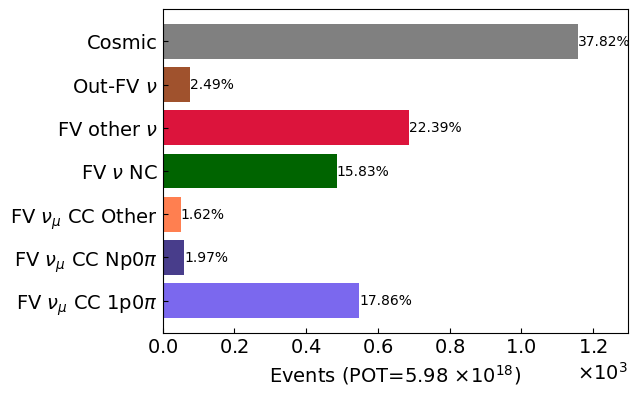

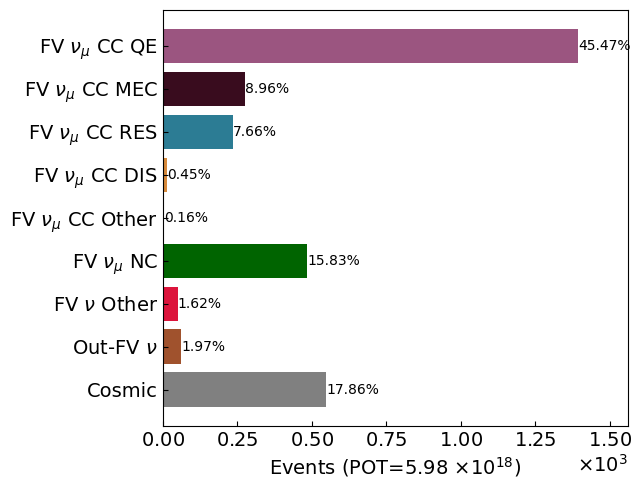

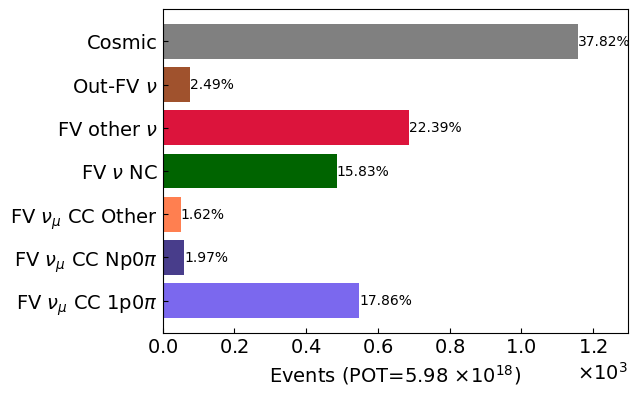

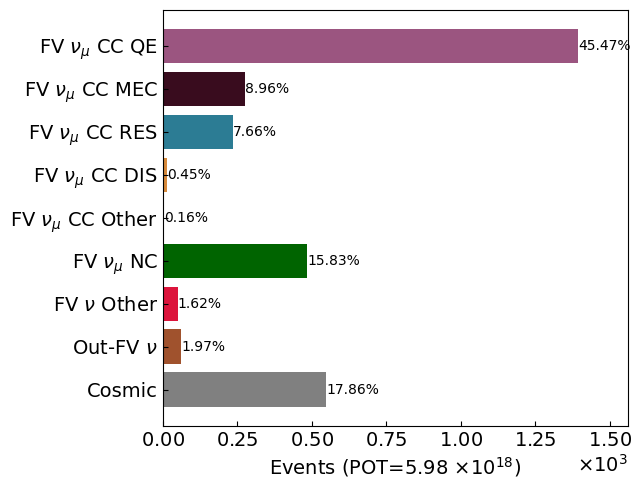

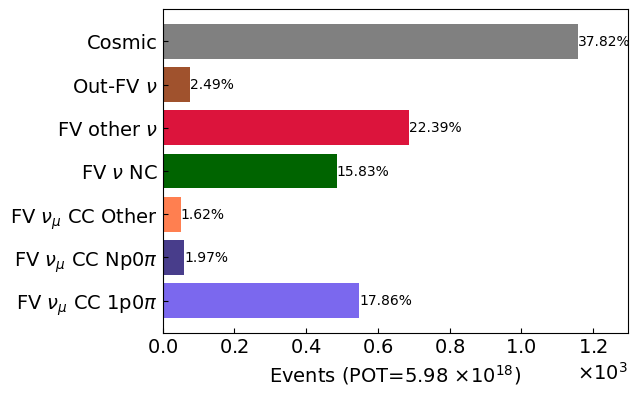

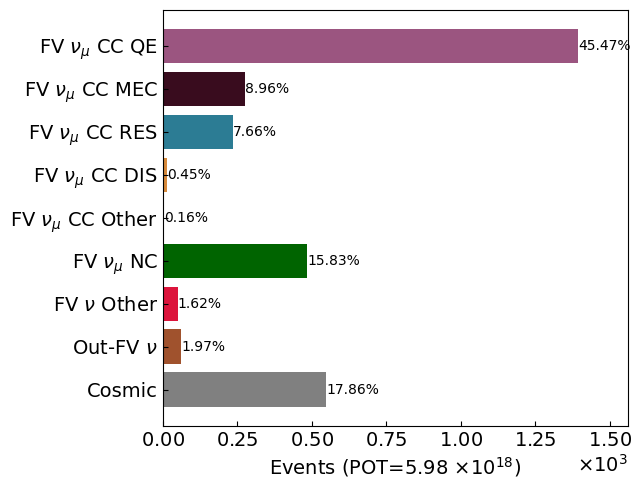

In [1111]:
stage_key = "2prong-contained"

for var_key in detvar_dfs.keys():
    mc_evt_df = detvar_dfs[var_key]['evt']

    mc_mask = InFV(mc_evt_df.t1.pfp.trk.end) & InFV(mc_evt_df.t2.pfp.trk.end)
    mc_evt_df_2prong = mc_evt_df[mc_mask]

    bar_type = "topology"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    bar_type = "genie"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    df_dict[var_key][stage_key] = mc_evt_df_2prong
    perc_dict_topo[var_key][stage_key] = ret_topo["perc_list"]
    perc_dict_genie[var_key][stage_key] = ret_genie["perc_list"]


/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:56: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[0] / total_mc_list[0])**2 +
/tmp/ipykernel_355689/735832279.py:57: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[i] / total_mc_list[i])**2


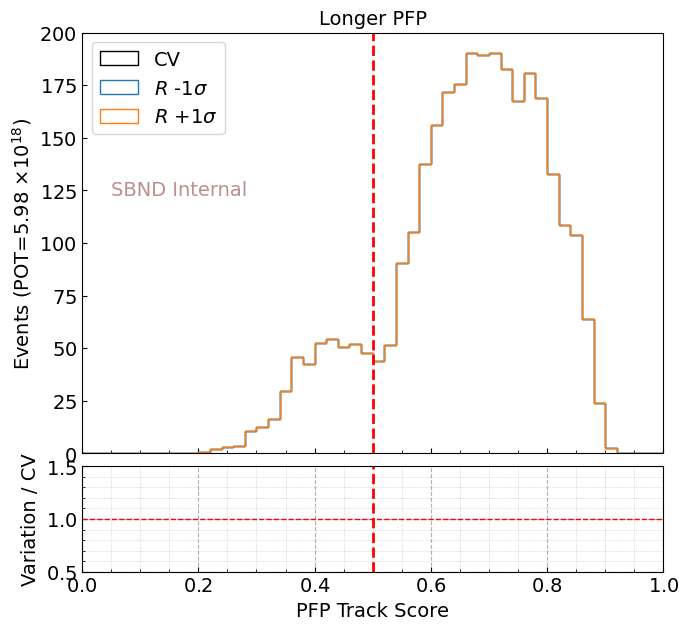

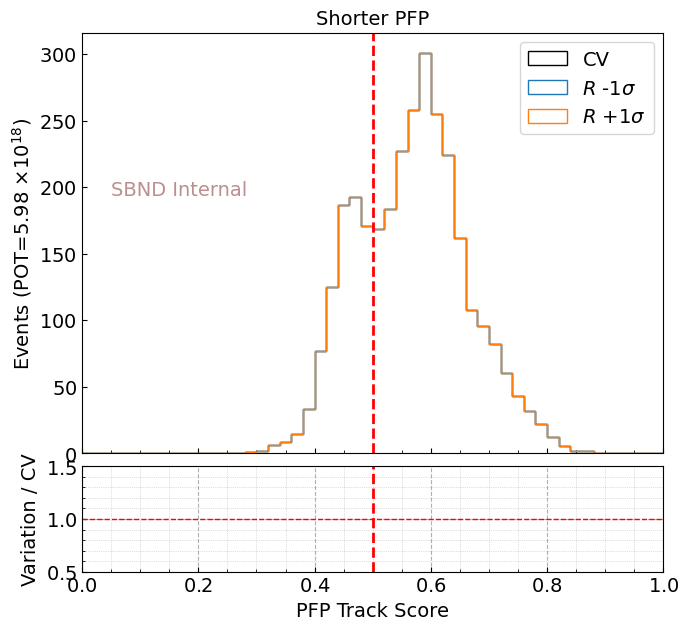

In [1112]:
# ==== PID scores for tracks in 2-prong slices ====
bins = np.linspace(0, 1, 51)
vline = [0.5]

evtdf = [df_dict[var_key]['2prong-contained'] for var_key in detvar_dfs.keys()]

vardf = [df.t1.pfp.trackScore for df in evtdf]
plot_labels = ["PFP Track Score", 
               "Events (POT={})".format(pot_str), "Longer PFP"]

save_name = save_fig_dir + "/pfp_trackscore_t1.png"
hist_plot(evtdf, vardf, bins,
          colors, labels,
          plot_labels,
          vline=vline,
          save_fig=save_fig, save_name=save_name)

vardf = [df.t2.pfp.trackScore for df in evtdf]
plot_labels = ["PFP Track Score", 
               "Events (POT={})".format(pot_str), "Shorter PFP"]

save_name = save_fig_dir + "/pfp_trackscore_t2.png"
hist_plot(evtdf, vardf, bins,
          colors, labels,
          plot_labels,
          vline=vline,
          save_fig=save_fig, save_name=save_name)

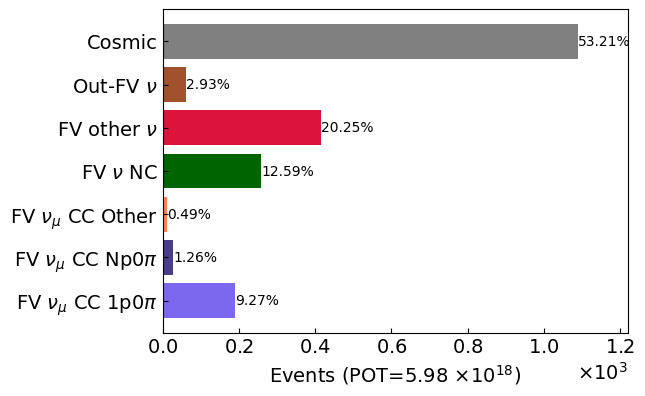

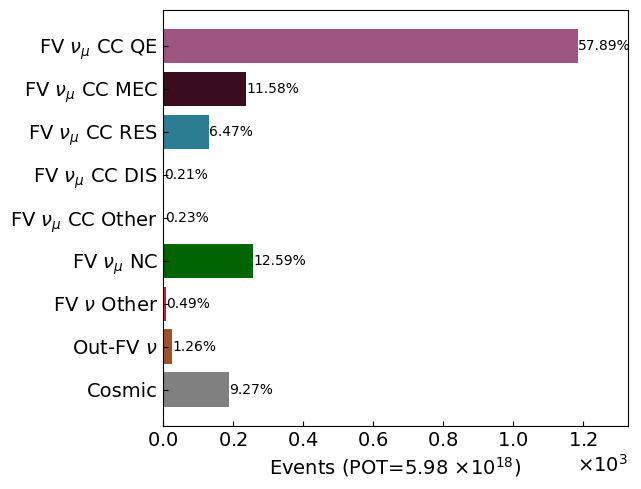

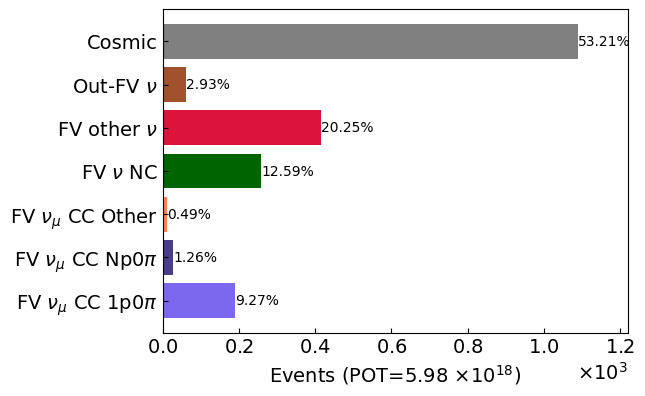

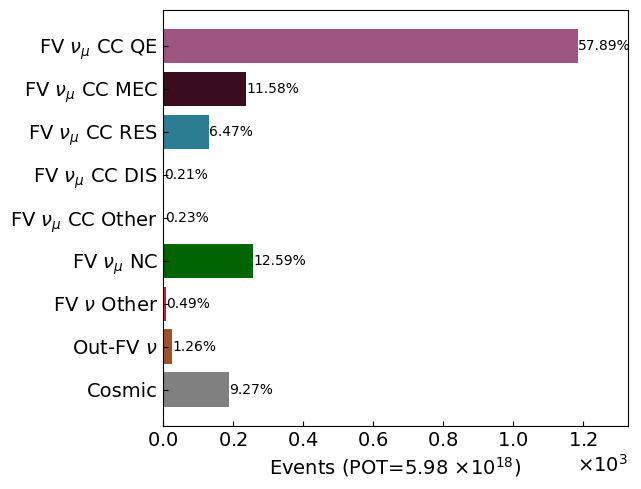

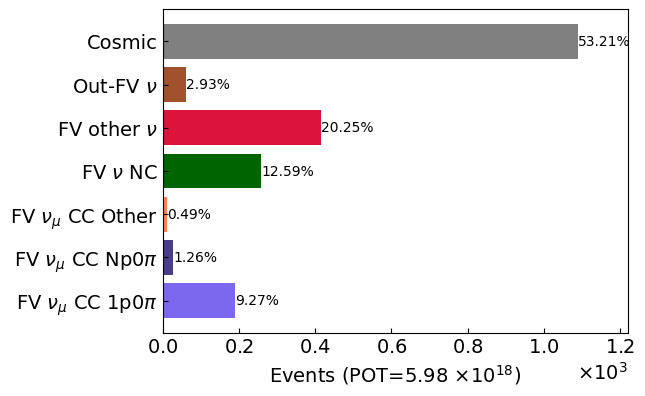

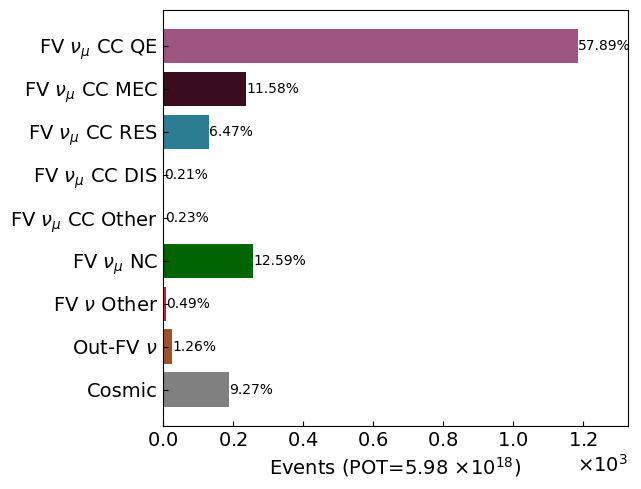

In [1113]:
# both track have trackscore > 0.5
stage_key = "2prong-trackscore"
trackscore_th = 0.5

for var_key in detvar_dfs.keys():
    mc_evt_df = df_dict[var_key]['2prong-contained']

    mc_mask = (mc_evt_df.t1.pfp.trackScore > trackscore_th) & (mc_evt_df.t2.pfp.trackScore > trackscore_th)
    mc_evt_df = mc_evt_df[mc_mask]

    bar_type = "topology"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    bar_type = "genie"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    df_dict[var_key][stage_key] = mc_evt_df
    perc_dict_topo[var_key][stage_key] = ret_topo["perc_list"]
    perc_dict_genie[var_key][stage_key] = ret_genie["perc_list"]

    mc_trk_df = detvar_dfs[var_key]['trk']
    mc_trk_df = mc_trk_df.reset_index(level=[3]).loc[mc_evt_df.index].reset_index().set_index(trk_indexnames)
    df_dict[var_key][stage_key+'-trk'] = mc_trk_df

In [1114]:
eps = 1e-8

/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:56: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[0] / total_mc_list[0])**2 +
/tmp/ipykernel_355689/735832279.py:57: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[i] / total_mc_list[i])**2


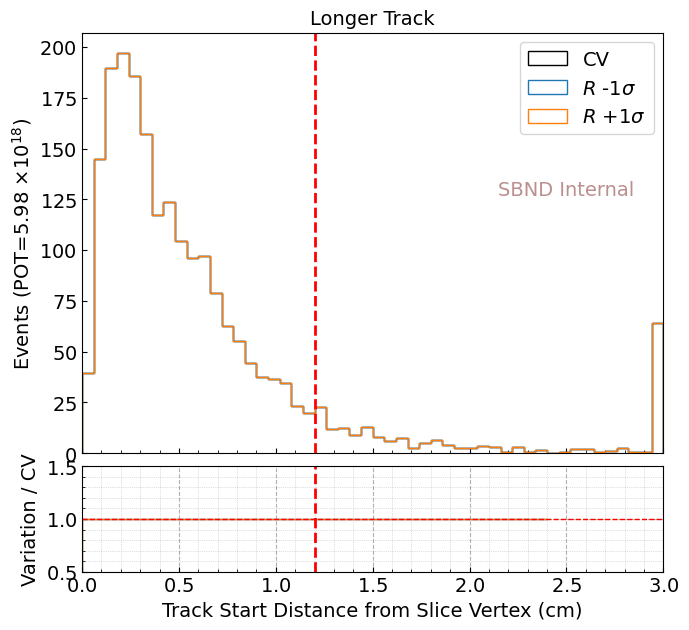

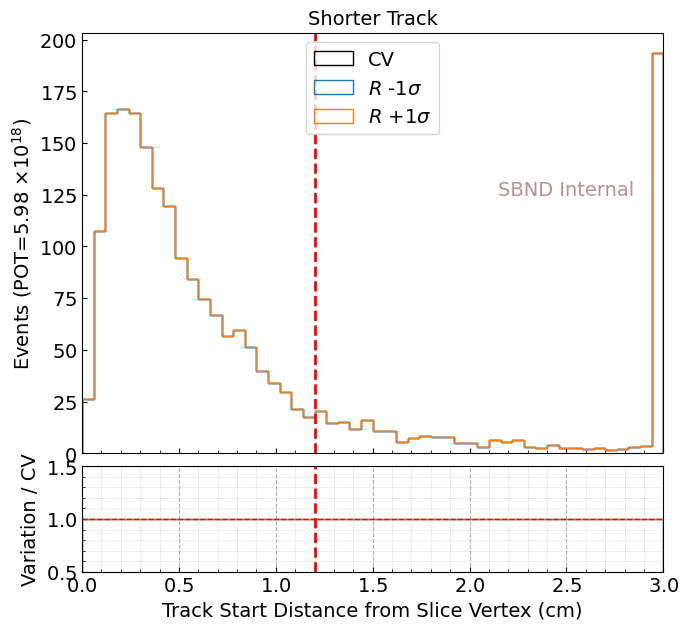

In [1115]:
# ==== PID scores for tracks in 2-prong slices ====
bins = np.linspace(0, 3, 51)
vline = [1.2]

evtdf = [df_dict[var_key]['2prong-trackscore'] for var_key in detvar_dfs.keys()]

vardf = [mag3d(df.t1.pfp.trk.start, df.slc.vertex) for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = ["Track Start Distance from Slice Vertex (cm)", 
               "Events (POT={})".format(pot_str), "Longer Track"]
save_name = save_fig_dir + "/start_vertex_dist_t1.png"
hist_plot(evtdf, vardf, bins,
          colors, labels,
          plot_labels,
          vline=vline,
          save_fig=save_fig, save_name=save_name)


vardf = [mag3d(df.t2.pfp.trk.start, df.slc.vertex) for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = ["Track Start Distance from Slice Vertex (cm)", 
               "Events (POT={})".format(pot_str), "Shorter Track"]

save_name = save_fig_dir + "/start_vertex_dist_t2.png"
hist_plot(evtdf, vardf, bins,
          colors, labels,
          plot_labels,
          vline=vline,
          save_fig=save_fig, save_name=save_name)

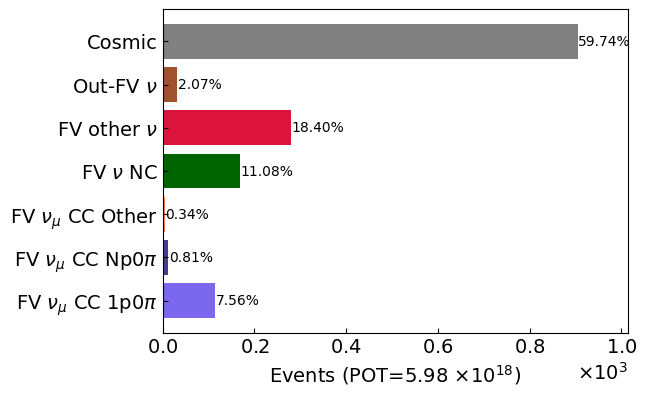

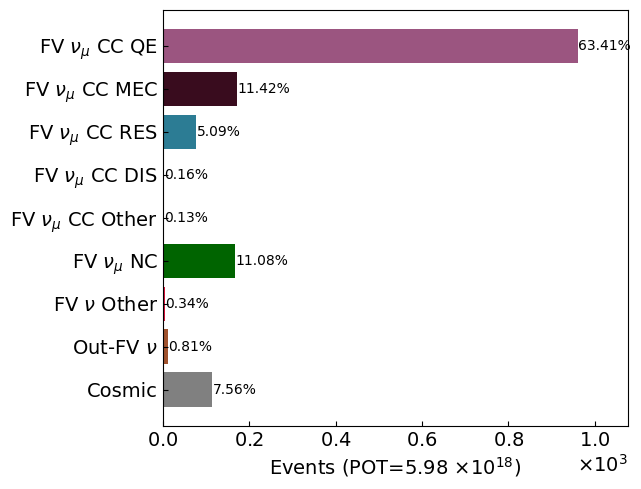

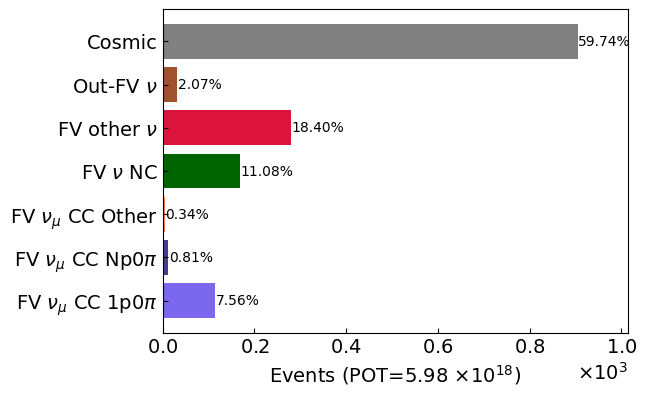

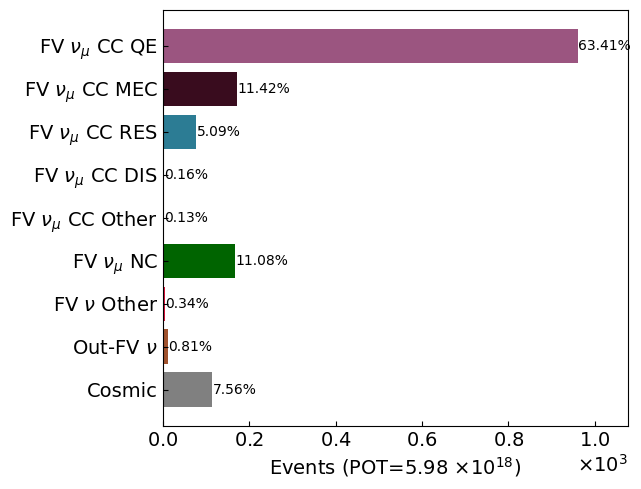

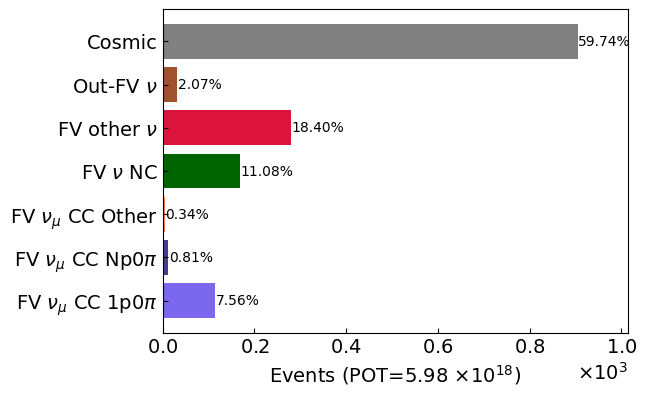

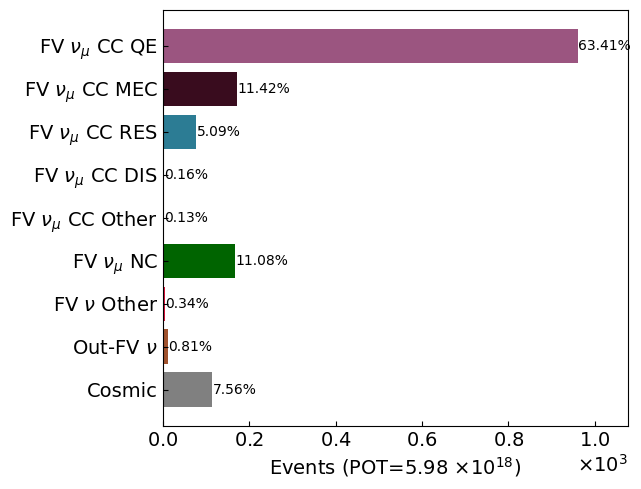

In [1116]:
# both start (position - vertex) < 1 cm
stage_key = "2prong-start_vertex_dist"
dist_th = 1.2

for var_key in detvar_dfs.keys():
    mc_evt_df = df_dict[var_key]['2prong-trackscore']
    
    mc_mask = (mag3d(mc_evt_df.t1.pfp.trk.start, mc_evt_df.slc.vertex) < dist_th) & (mag3d(mc_evt_df.t2.pfp.trk.start, mc_evt_df.slc.vertex) < dist_th)
    mc_evt_df = mc_evt_df[mc_mask]

    bar_type = "topology"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df,
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    bar_type = "genie"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df, 
                            plot_labels=plot_labels_bar,
                            save_fig=save_fig, save_name=save_name)

    df_dict[var_key][stage_key] = mc_evt_df
    perc_dict_topo[var_key][stage_key] = ret_topo["perc_list"]
    perc_dict_genie[var_key][stage_key] = ret_genie["perc_list"]

    # mc_trk_df = detvar_dfs[var_key]['trk']
    # mc_trk_df = mc_trk_df.loc[mc_evt_df.index]
    # detvar_dfs[var_key]['trk'] = mc_trk_df

    # mc_track1 = mc_track1.loc[mc_evt_df.index]
    # mc_track2 = mc_track2.loc[mc_evt_df.index]

# PID
- cut on track length & chi2 scores
- (MCS fwd P - MCS bwd P)
- quality cut on (range P - MCS P)
- TODO: number of daughter particles?

## Selection

In [1117]:
def avg_chi2(df, var_name, new=False):
    planes = ['I0', 'I1', 'I2']
    chi2_vals = []
    if new:
        var_name = var_name + "_new"
    for plane in planes:
        chi2 = df['pfp']['trk']['chi2pid'][plane][var_name]
        chi2_vals.append(chi2)
    chi2_df = pd.concat(chi2_vals, axis=1)
    # fill 0 with nan
    chi2_df = chi2_df.replace(0, np.nan)
    avg = chi2_df.mean(axis=1, skipna=True)
    return avg

In [1118]:
def range_p_mcs_p(df):
    frac_diff = (df.pfp.trk.rangeP.p_muon - df.pfp.trk.mcsP.fwdP_muon) / df.pfp.trk.rangeP.p_muon
    return frac_diff

### data vs. MC

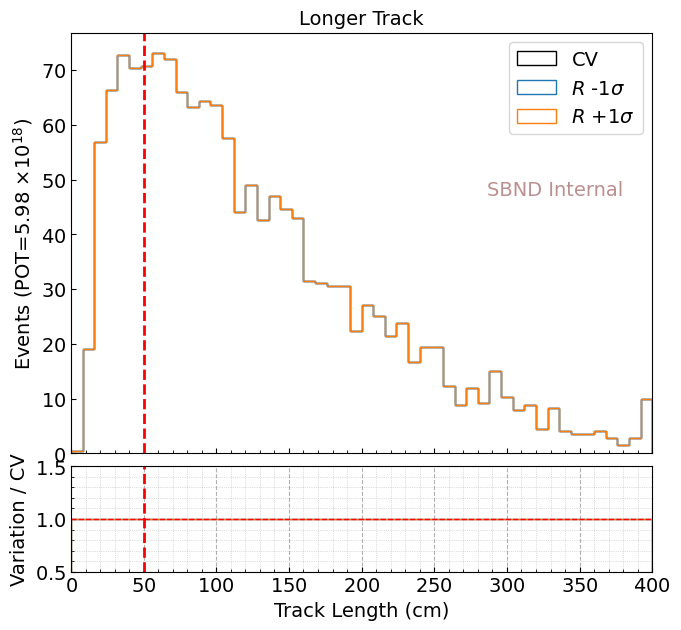

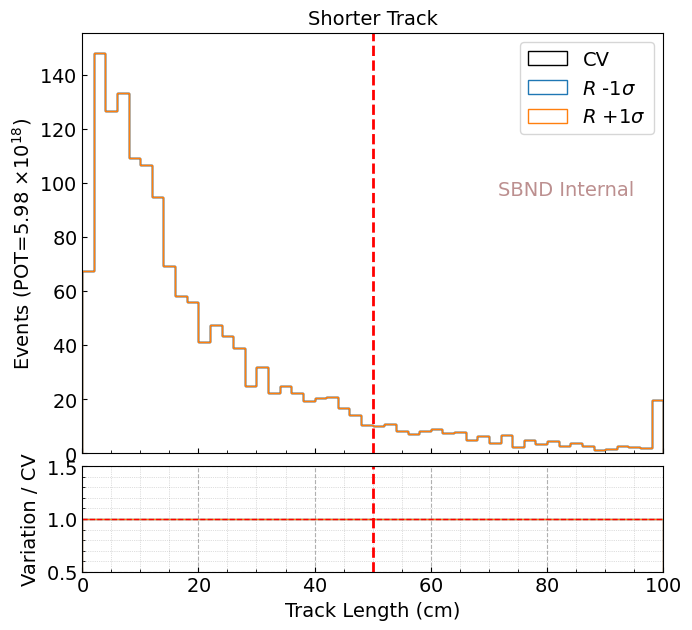

In [1119]:
vline = [50]
evtdf = [df_dict[var_key]['2prong-start_vertex_dist'] for var_key in detvar_dfs.keys()]

titles = ["Longer Track", "Shorter Track"]
for tidx, tbranch in enumerate(["t1", "t2"]):
    if tidx == 0:
        bins = np.linspace(0., 400, 51)
    if tidx == 1:
        bins = np.linspace(0., 100, 51)
    vardf = [df[tbranch].pfp.trk.len for df in evtdf]
    vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
    plot_labels = ["Track Length (cm)", 
                "Events (POT={})".format(pot_str), titles[tidx]]
    save_name = save_fig_dir + "/length_{}.png".format(tbranch)
    hist_plot(evtdf, vardf, bins,
            colors, labels,
            plot_labels,
            vline=vline,
            save_fig=save_fig, save_name=save_name)

/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: divide by zero encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:56: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[0] / total_mc_list[0])**2 +
/tmp/ipykernel_355689/735832279.py:57: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[i] / total_mc_list[i])**2
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


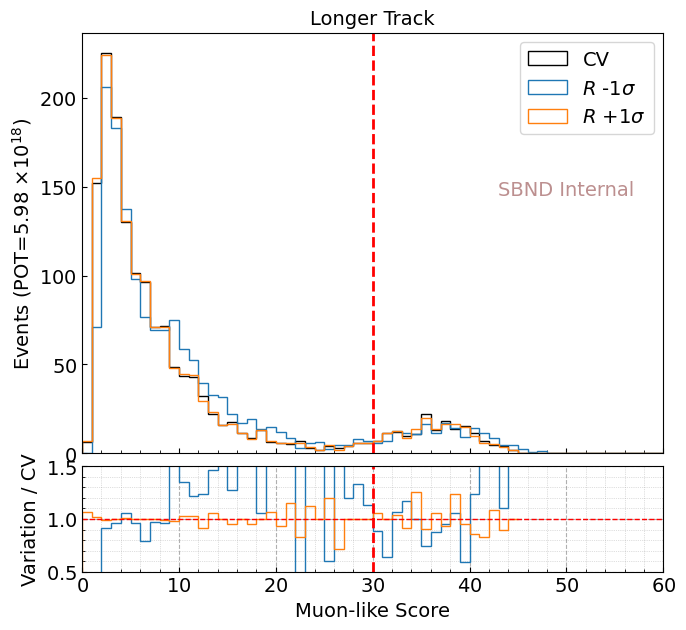

/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:56: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[0] / total_mc_list[0])**2 +
/tmp/ipykernel_355689/735832279.py:57: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[i] / total_mc_list[i])**2


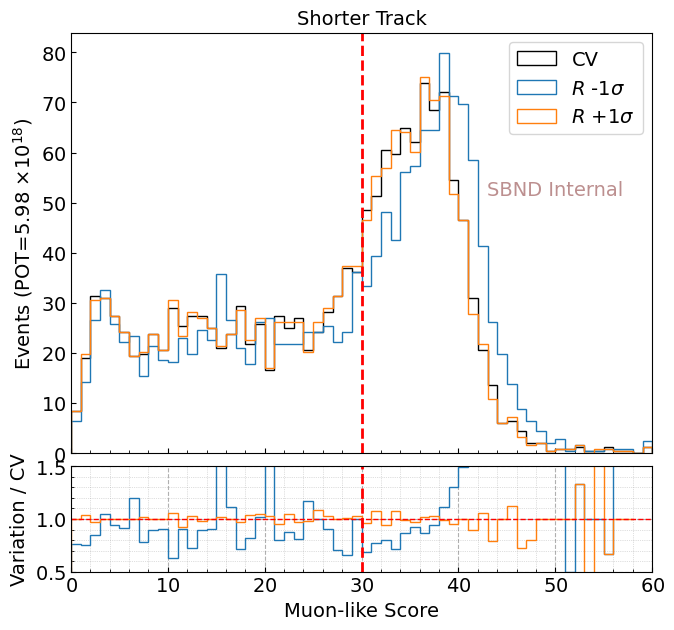

In [1120]:
# mc_trk_df_2prong["pot_weight"] = mc_pot_scale * np.ones(len(mc_trk_df_2prong))

bins = np.linspace(0, 60, 61)
vline = [30]

evtdf = [df_dict[var_key]['2prong-start_vertex_dist'] for var_key in detvar_dfs.keys()]

titles = ["Longer Track", "Shorter Track"]
for tidx, tbranch in enumerate(["t1", "t2"]):
    vardf = [avg_chi2(df[tbranch], "chi2_muon") for df in evtdf]
    vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
    plot_labels = ["Muon-like Score", 
                "Events (POT={})".format(pot_str), titles[tidx]]
    save_name = save_fig_dir + "/chi2muon_{}.png".format(tbranch)
    hist_plot(evtdf, vardf, bins,
            colors, labels,
            plot_labels,
            vline=vline,
            save_fig=save_fig, save_name=save_name)

/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: divide by zero encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:56: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[0] / total_mc_list[0])**2 +
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:57: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[i] / total_mc_list[i])**2


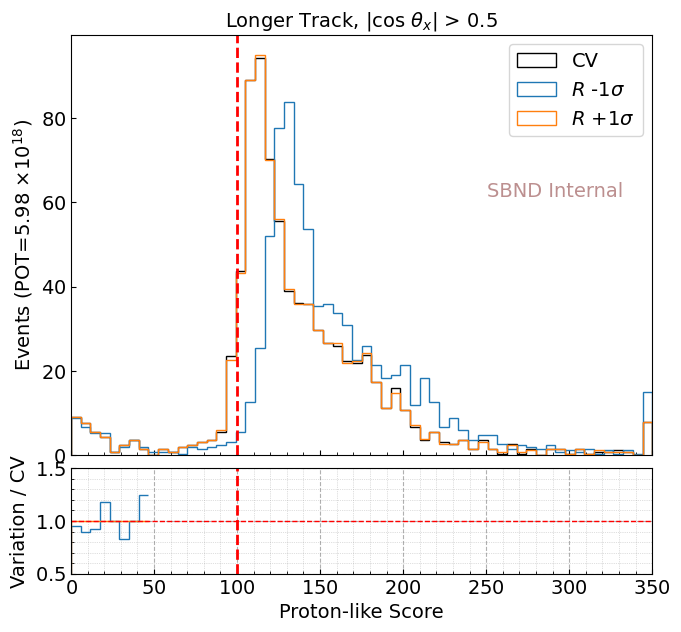

/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: divide by zero encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = total_mc_list[i] / total_mc_list[0]
/tmp/ipykernel_355689/735832279.py:56: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[0] / total_mc_list[0])**2 +
/tmp/ipykernel_355689/735832279.py:57: RuntimeWarning: invalid value encountered in divide
  (mc_stat_err_list[i] / total_mc_list[i])**2
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


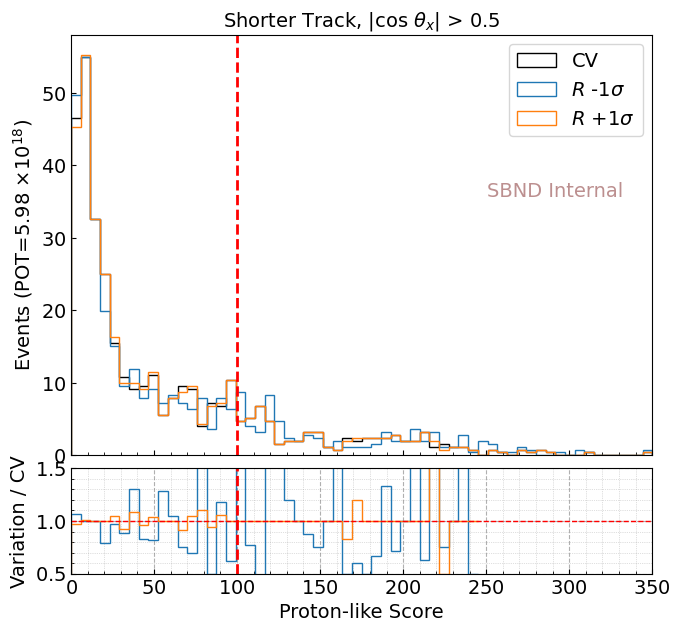

In [1121]:
bins = np.linspace(0, 350, 61)
vline = [100]

evtdf = [df_dict[var_key]['2prong-start_vertex_dist'] for var_key in detvar_dfs.keys()]

titles = ["Longer Track", "Shorter Track"]
for tidx, tbranch in enumerate(["t1", "t2"]):
    evtdf = [df[np.abs(df[tbranch].pfp.trk.dir.x) > 0.5] for df in evtdf]
    # evtdf = [df[np.abs(df[tbranch].pfp.trk.dir.x) < 0.1] for df in evtdf]
    vardf = [avg_chi2(df[tbranch], "chi2_proton") for df in evtdf]
    vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
    plot_labels = ["Proton-like Score", 
                "Events (POT={})".format(pot_str), titles[tidx] + r", |cos $\theta_x$| > 0.5"]
    save_name = save_fig_dir + "/chi2proton_{}.png".format(tbranch)
    hist_plot(evtdf, vardf, bins,
            colors, labels,
            plot_labels,
            vline=vline,
            save_fig=save_fig, save_name=save_name)

/tmp/ipykernel_355689/3377938155.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_candidates = mc_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)


chimu: 30, chip: 100, muon efficiency: 0.7778126964173476, purity: 0.9430645777607948
proton efficiency 0.8654768247202983
proton purity 0.9759687593872034
mc_mu_idx 2594
mc_p_idx 2857
mc_mu_p_idx 1917


/tmp/ipykernel_355689/3377938155.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_candidates = mc_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)


chimu: 30, chip: 100, muon efficiency: 0.8189817724701446, purity: 0.9426705370101597
proton efficiency 0.845107971207678
proton purity 0.9890795631825273
mc_mu_idx 2733
mc_p_idx 2790
mc_mu_p_idx 1979


/tmp/ipykernel_355689/3377938155.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_candidates = mc_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)


chimu: 30, chip: 100, muon efficiency: 0.7781269641734758, purity: 0.9430863254392666
proton efficiency 0.8654768247202983
proton purity 0.9762620192307693
mc_mu_idx 2595
mc_p_idx 2857
mc_mu_p_idx 1917


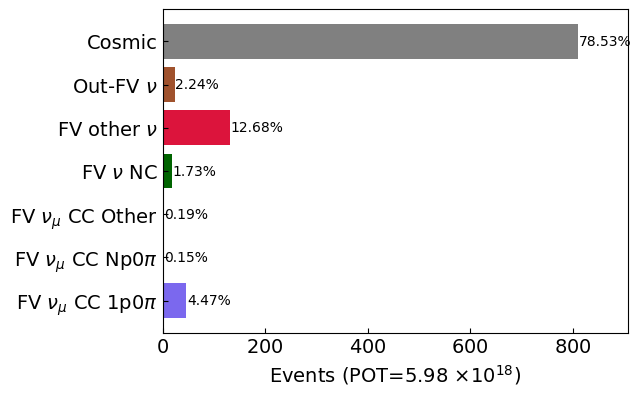

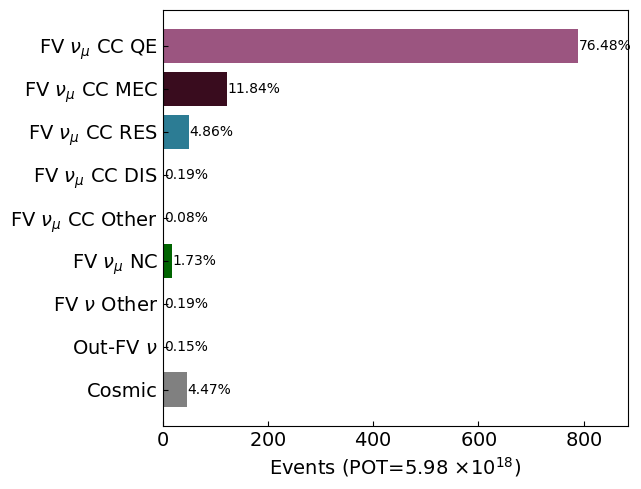

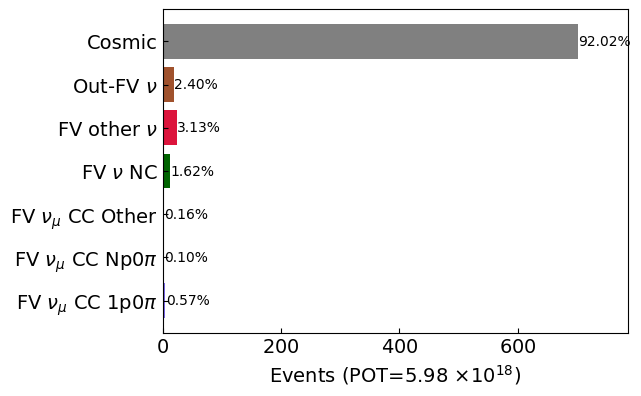

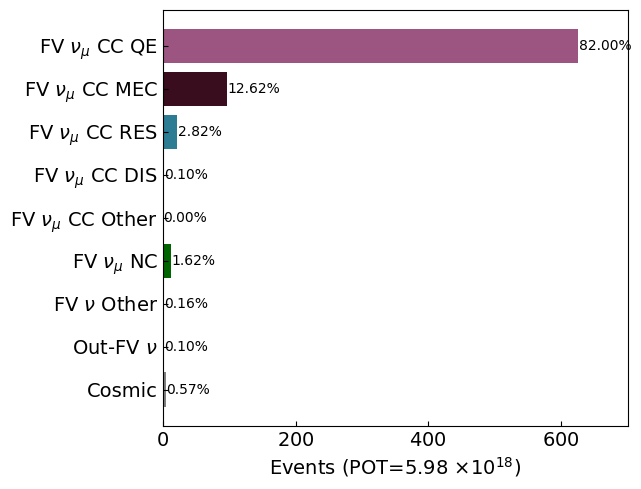

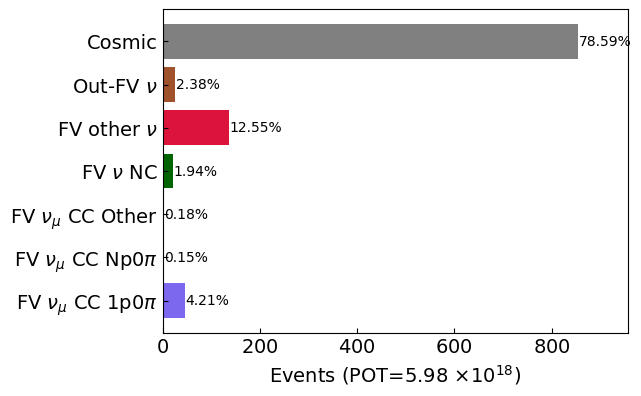

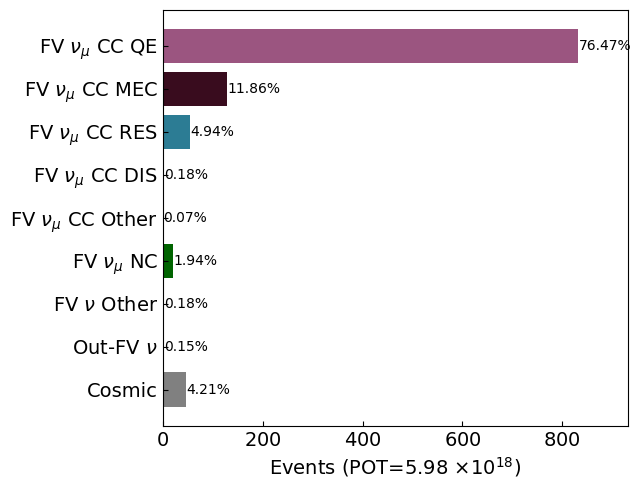

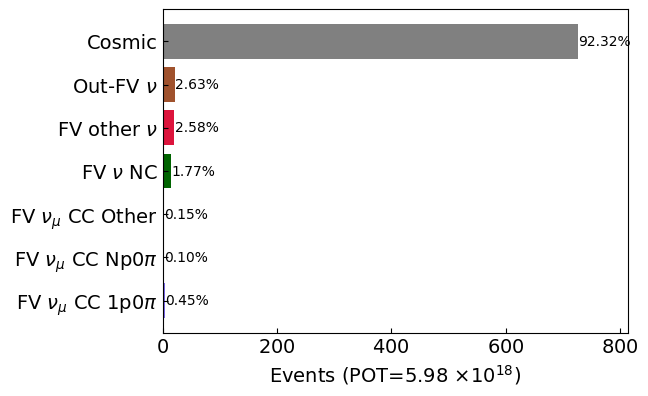

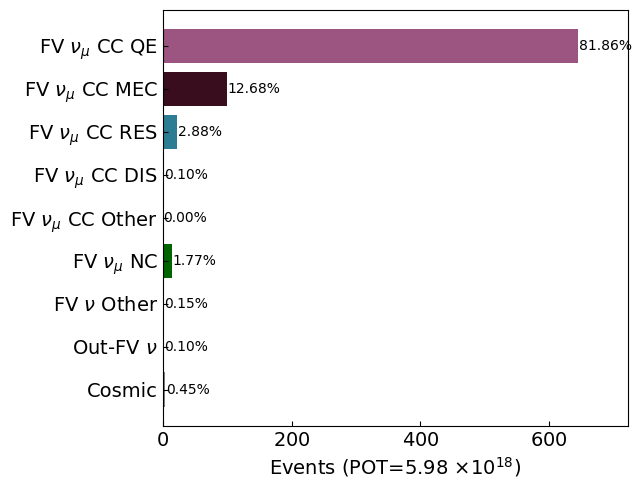

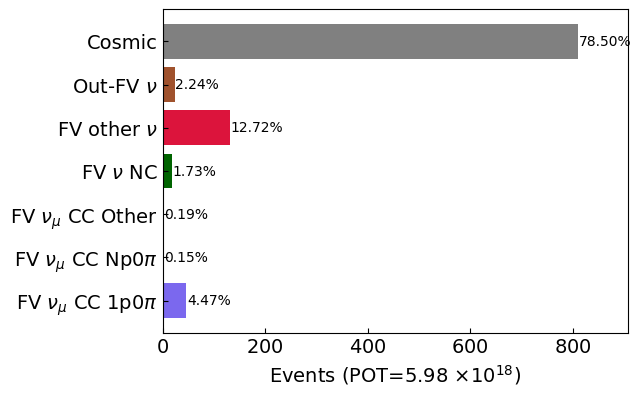

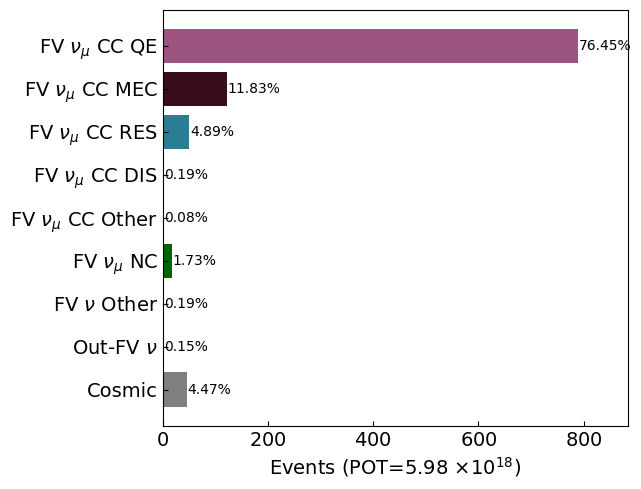

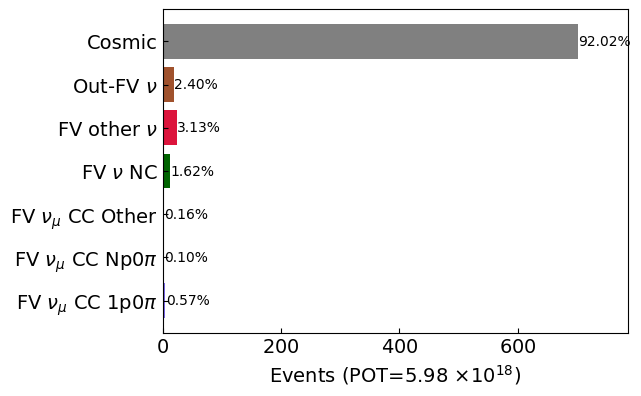

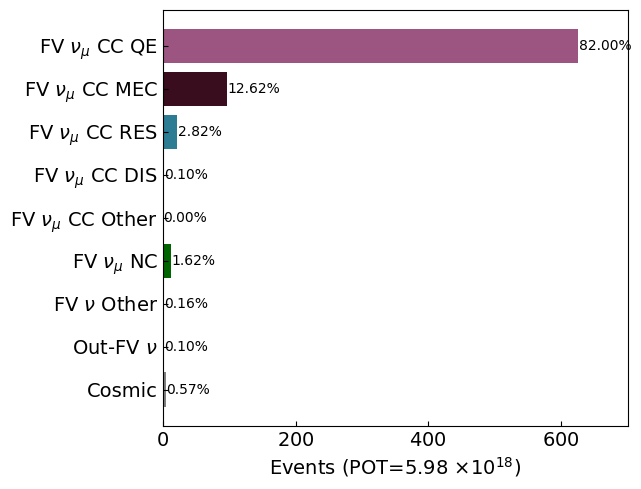

In [1122]:
mu_chi2mu_th = 30
mu_chi2p_th = 100
mu_len_th = 50
qual_th = 0.3

p_chi2p_th = 90

# ---- limit to the target kinematic range 
MASS_MUON = 0.1056583745
mu_low_th = 0.22
mu_hi_th = 1

MASS_PROTON = 0.938272081
p_low_th = 0.3
p_hi_th = 1


for var_key in detvar_dfs.keys():
    mc_evt_df = df_dict[var_key]['2prong-start_vertex_dist']
    mc_track1 = mc_evt_df.t1
    mc_track2 = mc_evt_df.t2
    trk_indexnames = list(mc_track1.index.names) + [("pfp", "tindex", "", "", "", "", "")]
    mc_trks_df = pd.concat([mc_track1.reset_index().set_index(trk_indexnames),
                                mc_track2.reset_index().set_index(trk_indexnames)])

    # ---- muon selection ----
    mc_chimu_avg = avg_chi2(mc_trks_df, "chi2_muon")
    mc_chip_avg = avg_chi2(mc_trks_df, "chi2_proton")

    mc_mu_cut = (mc_chimu_avg > 0) & (mc_chimu_avg < mu_chi2mu_th) \
            & (mc_chip_avg > mu_chi2p_th) \
            & (mc_trks_df.pfp.trk.len > 50)
    mc_mu_candidates = mc_trks_df[mc_mu_cut]
    mc_mu_candidates_prequal = mc_mu_candidates

    mc_mu_cut = mc_mu_cut & (np.abs((mc_trks_df.pfp.trk.rangeP.p_muon - mc_trks_df.pfp.trk.mcsP.fwdP_muon) / mc_trks_df.pfp.trk.rangeP.p_muon) < qual_th)
    mc_mu_candidates = mc_trks_df[mc_mu_cut]

    mc_mu_candidates = mc_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
    mc_mu_candidate = mc_mu_candidates.groupby(level=[0,1,2]).nth(0)

    mc_mu_eff = len(mc_mu_candidates[mc_mu_candidates.pfp.trk.truth.p.pdg == 13])/len(mc_trks_df[mc_trks_df.pfp.trk.truth.p.pdg == 13])
    mc_mu_purity = len(mc_mu_candidate[mc_mu_candidate.pfp.trk.truth.p.pdg == 13])/len(mc_mu_candidate)
    print("chimu: {}, chip: {}, muon efficiency: {}, purity: {}".format(mu_chi2mu_th, mu_chi2p_th, mc_mu_eff, mc_mu_purity))

    # ---- proton selection ----
    mc_trk_idx = mc_trks_df.index.difference(mc_mu_candidate.index)
    mc_not_mu_candidate = mc_trks_df.loc[mc_trk_idx]
    mc_chimu_avg = avg_chi2(mc_not_mu_candidate, "chi2_muon")
    mc_chip_avg = avg_chi2(mc_not_mu_candidate, "chi2_proton")

    mc_p_cut = (mc_chip_avg > 0) & (mc_chip_avg < p_chi2p_th)
    mc_p_candidates = mc_not_mu_candidate[mc_p_cut]
    print("proton efficiency", len(mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212])/len(mc_not_mu_candidate[mc_not_mu_candidate.pfp.trk.truth.p.pdg == 2212]))
    print("proton purity", len(mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212])/len(mc_p_candidates))

    # ---- limit to the target kinematic range ----
    mc_mu_candidate_nopcut = mc_mu_candidate
    mc_mu_kin_cut = (mc_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
    mc_mu_kin_cut = mc_mu_kin_cut & (mc_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
    mc_mu_candidate = mc_mu_candidate[mc_mu_kin_cut]

    mc_p_candidates_nopcut = mc_p_candidates
    mc_p_kin_cut = (mc_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
    mc_p_kin_cut = mc_p_kin_cut & (mc_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
    mc_p_candidates = mc_p_candidates[mc_p_kin_cut]

    # ---- select mu-X slice ----
    stage_key = "2prong-muX"
    mc_mu_idx = mc_mu_candidate.reset_index(level=[3]).index.unique()
    mc_evt_df_muX = mc_evt_df.loc[mc_mu_idx]
    
    bar_type = "topology"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_muX,
                    plot_labels=plot_labels_bar,
                    save_fig=save_fig, save_name=save_name)
    
    bar_type = "genie"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_muX, 
                    plot_labels=plot_labels_bar,
                    save_fig=save_fig, save_name=save_name)
    
    df_dict[var_key][stage_key] = mc_evt_df_muX
    perc_dict_topo[var_key][stage_key] = ret_topo["perc_list"]
    perc_dict_genie[var_key][stage_key] = ret_genie["perc_list"]
    
    # ---- select mu-p slice ----
    stage_key = "2prong-mup"
    mc_p_idx = mc_p_candidates.reset_index(level=[3]).index.unique()
    mc_mu_p_idx = mc_mu_idx.intersection(mc_p_idx)
    print("mc_mu_idx", len(mc_mu_idx))
    print("mc_p_idx", len(mc_p_idx))
    print("mc_mu_p_idx", len(mc_mu_p_idx))
    
    mc_evt_df_mup = mc_evt_df.loc[mc_mu_p_idx]
    bar_type = "topology"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_mup,
                    plot_labels=plot_labels_bar,
                    save_fig=save_fig, save_name=save_name)
    
    bar_type = "genie"
    save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
    ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_mup, 
                    plot_labels=plot_labels_bar,
                    save_fig=save_fig, save_name=save_name)
    
    df_dict[var_key][stage_key] = mc_evt_df_mup
    perc_dict_topo[var_key][stage_key] = ret_topo["perc_list"]
    perc_dict_genie[var_key][stage_key] = ret_genie["perc_list"]
    
    mc_mu_df = match_trkdf_to_slcdf(mc_mu_candidate, mc_evt_df_mup)
    mc_p_df = match_trkdf_to_slcdf(mc_p_candidates, mc_evt_df_mup)
    mc_mu_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_mu_df))
    mc_p_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_p_df))
    df_dict[var_key][stage_key+"_mu"] = mc_mu_df
    df_dict[var_key][stage_key+"_p"] = mc_p_df

## Efficiency

In [1123]:
import statsmodels.api as sm

def eff_err(success,total):  # success/total
    err = [[],[]]
    eff = success/total
    for i in range(len(success)):
        this_success = success[i]
        this_tot = total[i]
        interval = sm.stats.proportion_confint(this_success,this_tot,method='wilson')
        err[0].append(abs(eff[i]-interval[0]))
        err[1].append(abs(eff[i]-interval[1]))
    return err

In [1124]:
# fig, ax = plt.subplots()
# var_name = ("pfp", "trk", "truth", "p", "totp")
# bins = np.linspace(0, 1.5, 41)
# bin_centers = (bins[:-1] + bins[1:])/2

# var_precut = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13][var_name]
# var_postcut_prepcut = mc_mu_candidate_nopcut[mc_mu_candidate_nopcut.pfp.trk.truth.p.pdg == 13][var_name]
# var_postcut = mc_mu_candidate[mc_mu_candidate.pfp.trk.truth.p.pdg == 13][var_name]
# var_postcut_all = mc_mu_candidate[var_name]
# n_precut, _, _ = ax.hist(var_precut, bins=bins, histtype="step", alpha=0.75)
# n_postcut_prepcut, _, _ = ax.hist(var_postcut_prepcut, bins=bins, histtype="step", alpha=0.75)
# n_postcut, _, _ = ax.hist(var_postcut, bins=bins, histtype="step", alpha=0.75)
# n_postcut_all, _ = np.histogram(var_postcut_all, bins=bins)
# ax.set_xlabel("True Muon Momentum [GeV/c]")
# ax.set_ylabel("Tracks")

# ax_eff = ax.twinx()
# n_postcut = np.array(n_postcut)
# n_precut = np.array(n_precut)
# n_postcut_prepcut = np.array(n_postcut_prepcut)
# n_postcut_all = np.array(n_postcut_all)
# eff = n_postcut / n_precut
# eff_errval = eff_err(n_postcut, n_precut)
# eff_prepcut = n_postcut_prepcut / n_precut
# eff_prepcut_errval = eff_err(n_postcut_prepcut, n_precut)
# pur = n_postcut / n_postcut_all
# ax_eff.errorbar(bin_centers, eff, yerr=eff_errval, fmt="o-", color="k")
# # ax_eff.plot(bin_centers, eff_prepcut, color="gray")
# ax_eff.errorbar(bin_centers, eff_prepcut, yerr=eff_prepcut_errval, fmt="o-", color="gray")
# eff_threshold = bins[np.where(eff > 0.5)[0][0]]
# print("threshold: ", eff_threshold)
# ax_eff.axvline(0.22, color="red", linestyle="--")
# ax_eff.axvline(1, color="red", linestyle="--")
# # ax_eff.text(eff_threshold, 0.5, "50% Threshold={:.2f}".format(eff_threshold), color="red", fontsize=12)

# ax_eff.set_ylabel("Efficiency")
# ax_eff.set_ylim(0, 1.05)
# plt.xlim(bins[0], bins[-1])

# # legend using dummies
# plt.plot([], [], label="Tracks in 2-prong Slices", alpha=0.75, color="C0")
# plt.plot([], [], label="After Muon PID", alpha=0.75, color="C1")
# plt.plot([], [], label="After Muon PID + Kinematic Cut", alpha=0.75, color="C2")
# plt.plot([], [], label="Muon PID Eff.", color="gray")
# plt.plot([], [], label="Muon PID + Kinematic Cut Eff.", color="k")
# plt.plot([], [], label="Signal Muon Threshold", color="red", linestyle="--")
# plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
# plt.text(0.38, 0.03, "SBND Simulation\nSBND Internal", transform=plt.gca().transAxes, 
#          fontsize=12, color='rosybrown', ha='center', va='bottom')
# plt.title("Muon Candidate Selection")


# save_name = save_fig_dir + "/muon_candidate_selection_eff.png"
# if save_fig:
#     plt.savefig(save_name, dpi=300, bbox_inches="tight")
# plt.show()

# print("---- muon candidate selection ----")
# print("integrated efficiency: {:.2f}".format(n_postcut.sum() / n_precut.sum()))
# print("integrated purity: {:.2f}".format(n_postcut.sum() / len(mc_mu_candidate)))



In [1125]:
# fig, ax = plt.subplots()
# # var_name = ("pfp", "trk", "rangeP", "p_proton")
# var_name = ("pfp", "trk", "truth", "p", "totp")
# var_precut = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 2212][var_name]
# var_postcut_prepcut = mc_p_candidates_nopcut[mc_p_candidates_nopcut.pfp.trk.truth.p.pdg == 2212][var_name]
# var_postcut = mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212][var_name]
# var_postcut_all = mc_p_candidates[var_name]
# n_precut, _, _ = ax.hist(var_precut, bins=bins, histtype="step", alpha=0.75)
# n_postcut_prepcut, _, _ = ax.hist(var_postcut_prepcut, bins=bins, histtype="step", alpha=0.75)
# n_postcut, _, _ = ax.hist(var_postcut, bins=bins, histtype="step", alpha=0.75)
# n_postcut_all, _ = np.histogram(var_postcut_all, bins=bins)
# ax.set_xlabel("True Proton Momentum [GeV/c]")
# ax.set_ylabel("Tracks")

# ax_eff = ax.twinx()
# n_postcut = np.array(n_postcut)
# n_precut = np.array(n_precut)
# n_postcut_prepcut = np.array(n_postcut_prepcut)
# n_postcut_all = np.array(n_postcut_all)
# eff = n_postcut / n_precut
# eff_prepcut = n_postcut_prepcut / n_precut
# pur = n_postcut / n_postcut_all
# bin_centers = (bins[:-1] + bins[1:])/2
# eff_errval = eff_err(n_postcut, n_precut)
# eff_prepcut_errval = eff_err(n_postcut_prepcut, n_precut)
# ax_eff.errorbar(bin_centers, eff, yerr=eff_errval, fmt="o-", color="k")
# ax_eff.errorbar(bin_centers, eff_prepcut, yerr=eff_prepcut_errval, fmt="o-", color="gray")
# eff_threshold = bins[np.where(eff > 0.5)[0][0]]
# print("threshold: ", eff_threshold)
# ax_eff.axvline(0.3, color="red", linestyle="--")
# ax_eff.axvline(1, color="red", linestyle="--")

# ax_eff.set_ylabel("Efficiency")
# ax_eff.set_ylim(0, 1.05)

# plt.xlim(bins[0], bins[-1])

# # legend using dummies
# plt.plot([], [], label="Tracks in 2-prong Slices", alpha=0.75, color="C0")
# plt.plot([], [], label="After Proton PID", alpha=0.75, color="C1")
# plt.plot([], [], label="After Proton PID + Kinematic Cut", alpha=0.75, color="C2")
# plt.plot([], [], label="Proton PID Eff.", color="gray")
# plt.plot([], [], label="Proton PID + Kinematic Cut Eff.", color="k")
# plt.plot([], [], label="Signal Proton Threshold", color="red", linestyle="--")
# plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
# plt.text(0.4, 0.03, "SBND Simulation\nSBND Internal", transform=plt.gca().transAxes, 
#          fontsize=12, color='rosybrown', ha='center', va='bottom')
# plt.title("Proton Candidate Selection")

# save_name = save_fig_dir + "/proton_candidate_selection_eff.png"
# if save_fig:
#     plt.savefig(save_name, dpi=300, bbox_inches="tight")
# plt.show()

# print("---- proton candidate selection ----")
# print("integrated efficiency: {:.2f}".format(n_postcut.sum() / n_precut.sum()))
# print("integrated purity: {:.2f}".format(n_postcut.sum() / len(mc_p_candidates)))

# Results

## data vs. MC of measurement variables

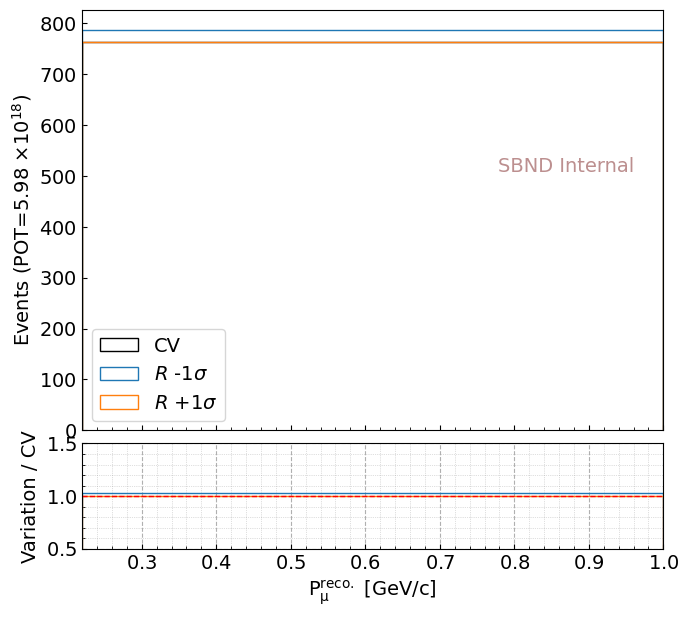

In [1126]:
# single bin
var_config = VariableConfig.muon_momentum()
bins = np.array([var_config.bins[0], var_config.bins[-1]])

evtdf = [df_dict[var_key]['2prong-mup_mu'] for var_key in detvar_dfs.keys()]
vardf = [df.pfp.trk.rangeP.p_muon for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/single_bin.png"
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)

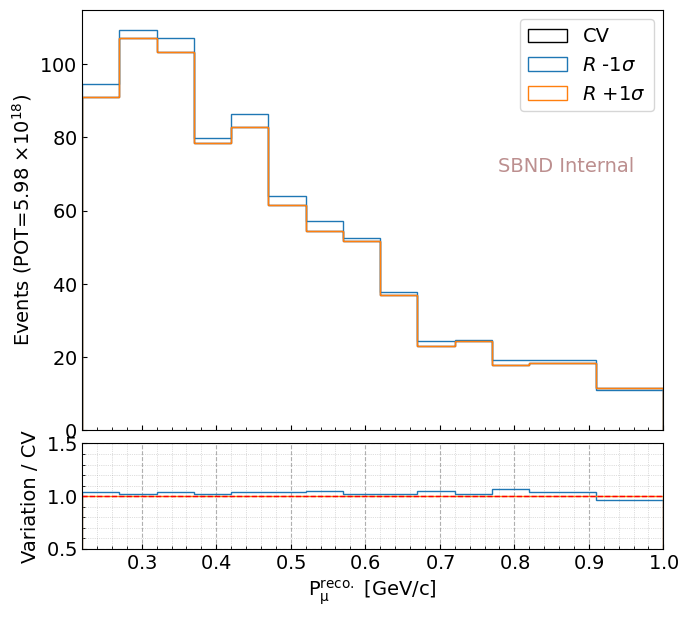

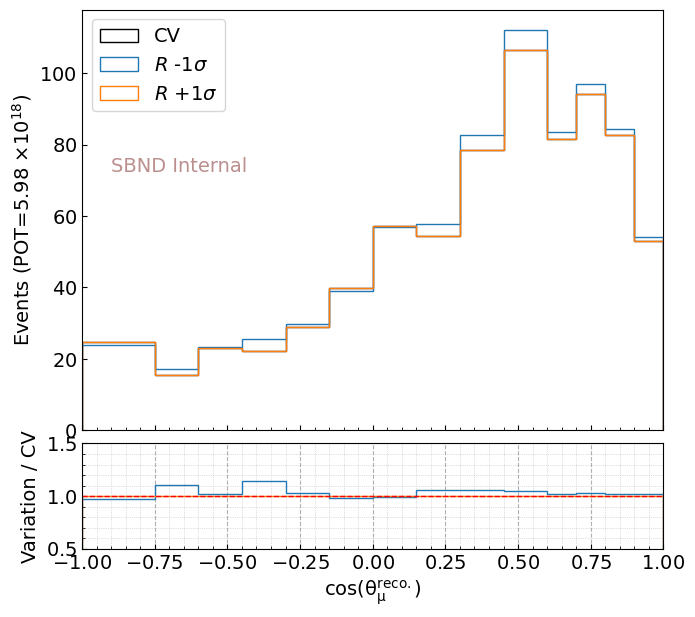

In [1127]:
var_config = VariableConfig.muon_momentum()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup_mu'] for var_key in detvar_dfs.keys()]
vardf = [df.pfp.trk.rangeP.p_muon for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)

var_config = VariableConfig.muon_direction()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup_mu'] for var_key in detvar_dfs.keys()]
vardf = [df.pfp.trk.dir.z for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)

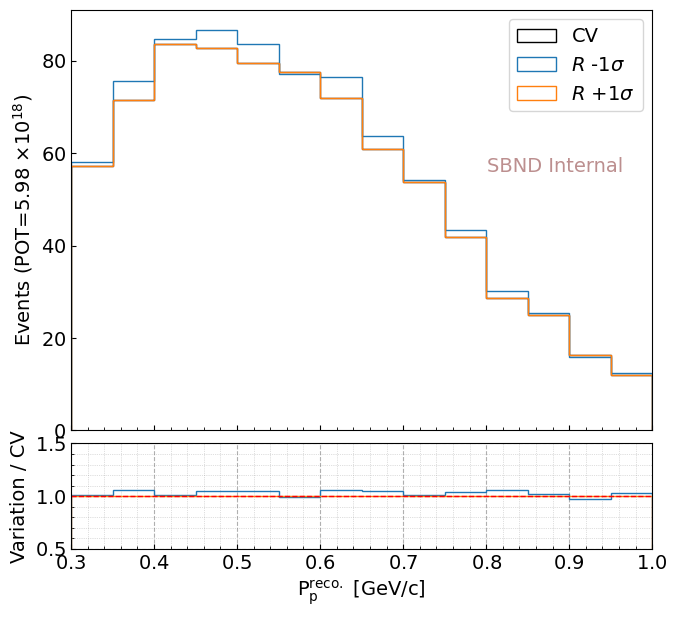

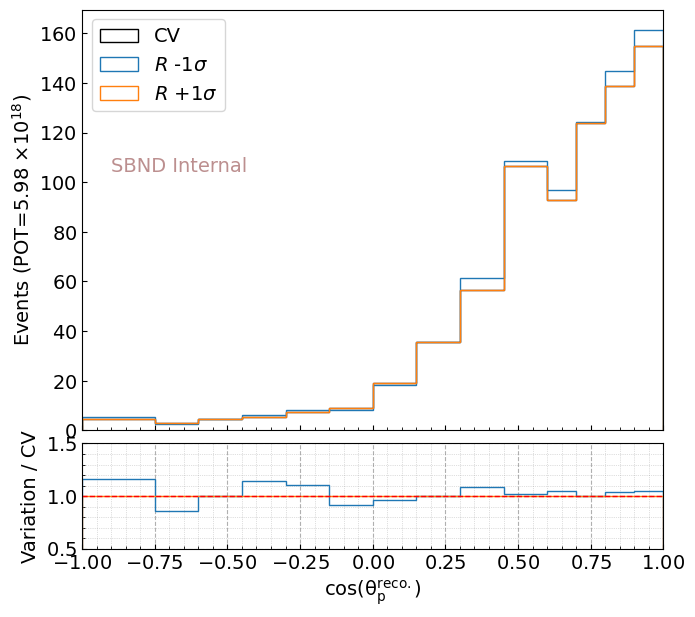

In [1128]:
var_config = VariableConfig.proton_momentum()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup_p'] for var_key in detvar_dfs.keys()]
vardf = [df.pfp.trk.rangeP.p_proton for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)

var_config = VariableConfig.proton_direction()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup_p'] for var_key in detvar_dfs.keys()]
vardf = [df.pfp.trk.dir.z for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)

In [1129]:
from pyanalib.pandas_helpers import pad_column_name
from pyanalib.variable_calculator import get_cc1p0pi_tki

for var_key in detvar_dfs.keys():
    mc_evt_df = df_dict[var_key]['2prong-mup']
    mudf = df_dict[var_key]['2prong-mup_mu'].reset_index(level=[3])
    pdf = df_dict[var_key]['2prong-mup_p'].reset_index(level=[3])
    P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
    P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
    mc_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

    df_dict[var_key]['2prong-mup']["del_Tp_x"] = mc_ret_tki["del_Tp_x"]
    df_dict[var_key]['2prong-mup']["del_Tp_y"] = mc_ret_tki["del_Tp_y"]
    df_dict[var_key]['2prong-mup']["del_Tp"] = mc_ret_tki["del_Tp"]
    df_dict[var_key]['2prong-mup']["del_p"] = mc_ret_tki["del_p"]
    df_dict[var_key]['2prong-mup']["del_alpha"] = mc_ret_tki["del_alpha"]
    df_dict[var_key]['2prong-mup']["del_phi"] = mc_ret_tki["del_phi"]
    
    # mc_evt_df["del_Tp_x"] = mc_ret_tki["del_Tp_x"]
    # mc_evt_df["del_Tp_y"] = mc_ret_tki["del_Tp_y"]
    # mc_evt_df["del_Tp"] = mc_ret_tki["del_Tp"]
    # mc_evt_df["del_p"] = mc_ret_tki["del_p"]
    # mc_evt_df["del_alpha"] = mc_ret_tki["del_alpha"]
    # mc_evt_df["del_phi"] = mc_ret_tki["del_phi"]

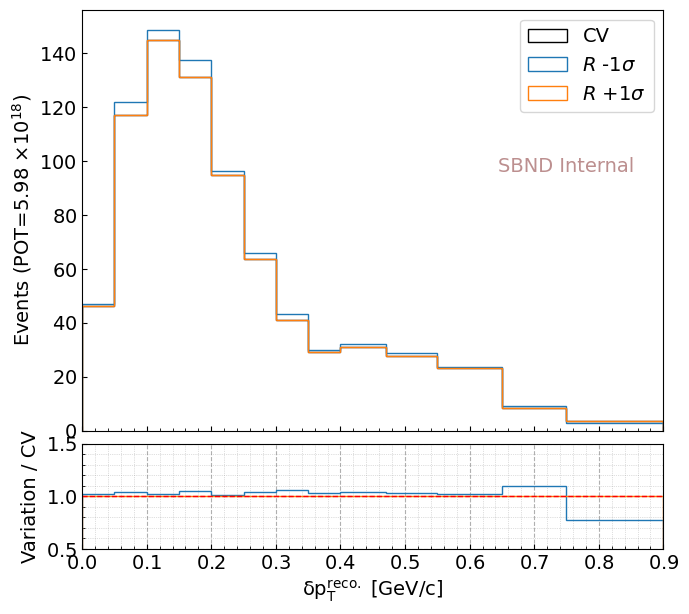

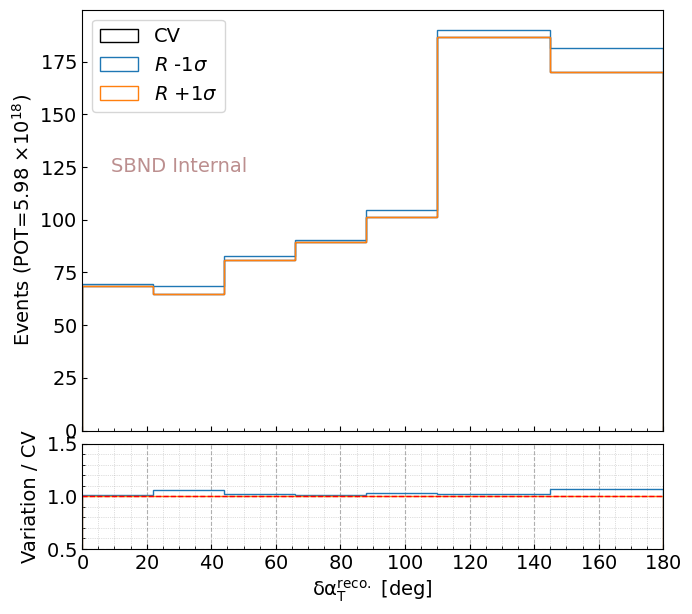

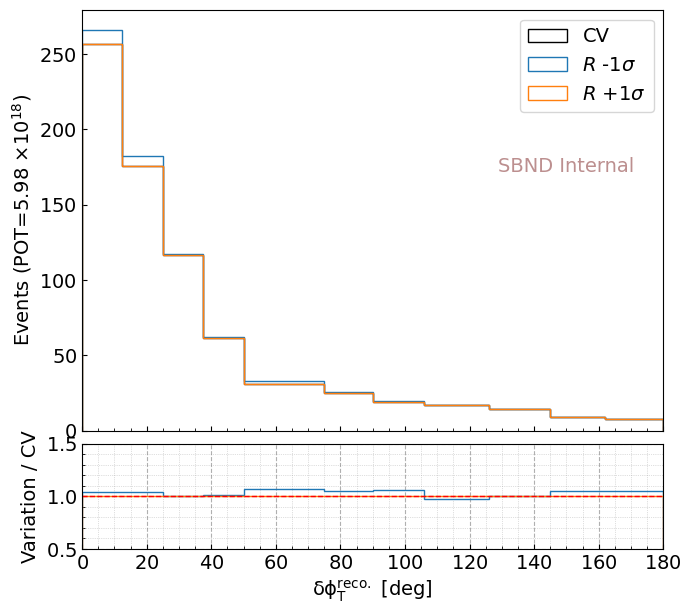

In [1130]:
var_config = VariableConfig.tki_del_Tp()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup'] for var_key in detvar_dfs.keys()]
vardf = [df.del_Tp for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)

var_config = VariableConfig.tki_del_alpha()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup'] for var_key in detvar_dfs.keys()]
vardf = [df.del_alpha for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins, 
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)


var_config = VariableConfig.tki_del_phi()
bins = var_config.bins
evtdf = [df_dict[var_key]['2prong-mup'] for var_key in detvar_dfs.keys()]
vardf = [df.del_phi for df in evtdf]
vardf = [np.clip(df, bins[0], bins[-1] - eps) for df in vardf]
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]
approval = "preliminary"
save_name = save_fig_dir + "/{}.png".format(var_config.var_save_name)
hist_plot(evtdf, vardf, bins,
        colors, labels,
        plot_labels,
        vline=[],
        save_fig=save_fig, save_name=save_name)
